In [1]:
cd ..

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/Users/joeranbosma/opt/anaconda3/envs/mlip/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/Users/joeranbosma/opt/anaconda3/envs/mlip/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv


In [3]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Pinball Loss function for Keras

In [4]:
train_df = pd.read_csv("custom_layer/features.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets.csv", index_col=0)

In [5]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [6]:
target_df.head()

,0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995
date,,,,,,,,,
2011-01-29,0.410956,0.494101,0.630373,0.671720,0.756835,0.843188,0.884852,1.006654,1.097859
2011-01-30,0.919469,0.992795,1.270255,1.332988,1.504236,1.675052,1.746716,2.014860,2.188142
2011-01-31,0.790407,0.988427,1.249410,1.322885,1.500305,1.659404,1.720131,1.953909,2.180639
2011-02-01,0.414008,0.487010,0.623712,0.659987,0.747542,0.837403,0.876519,1.000635,1.067878
2011-02-02,0.443139,0.511417,0.619042,0.662347,0.756661,0.838183,0.875509,0.997830,1.074211


In [7]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    x = Dense(len(quantiles))(x)  # returns 9 points, one for each quantile
    out = x

    model = Model(inputs=inp, outputs=out)

    return model

In [8]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 27        
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
___________________________________________________________

In [9]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_val, y_val))

Epoch 1/300
9/9 [==============================] - 0s 18ms/step - loss: 0.9200 - val_loss: 0.7823
Epoch 2/300
9/9 [==============================] - 0s 4ms/step - loss: 0.7758 - val_loss: 0.7042
Epoch 3/300
9/9 [==============================] - 0s 4ms/step - loss: 0.7227 - val_loss: 0.6519
Epoch 4/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6889 - val_loss: 0.6158
Epoch 5/300
9/9 [==============================] - 0s 3ms/step - loss: 0.6595 - val_loss: 0.5858
Epoch 6/300
9/9 [==============================] - 0s 3ms/step - loss: 0.6275 - val_loss: 0.5582
Epoch 7/300
9/9 [==============================] - 0s 3ms/step - loss: 0.5993 - val_loss: 0.5295
Epoch 8/300
9/9 [==============================] - 0s 3ms/step - loss: 0.5668 - val_loss: 0.5154
Epoch 9/300
9/9 [==============================] - 0s 3ms/step - loss: 0.5397 - val_loss: 0.4781
Epoch 10/300
9/9 [==============================] - 0s 3ms/step - loss: 0.5020 - val_loss: 0.4477
Epoch 11/300
9/9 [==========

9/9 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0295
Epoch 85/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0302 - val_loss: 0.0300
Epoch 86/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0265
Epoch 87/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0317 - val_loss: 0.0377
Epoch 88/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0430
Epoch 89/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0274
Epoch 90/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 0.0354
Epoch 91/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0298
Epoch 92/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0205
Epoch 93/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0192
Epoch 94/300
9/9 [===============

9/9 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 168/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0113
Epoch 169/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0162
Epoch 170/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0108
Epoch 171/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0208
Epoch 172/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0182 - val_loss: 0.0159
Epoch 173/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0168 - val_loss: 0.0211
Epoch 174/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0212
Epoch 175/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0188 - val_loss: 0.0161
Epoch 176/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0187
Epoch 177/300
9/9 [=====

Epoch 250/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0104
Epoch 251/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0175
Epoch 252/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0243
Epoch 253/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0262
Epoch 254/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.0115
Epoch 255/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 256/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0132
Epoch 257/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 258/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0204
Epoch 259/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0145
Epoch 260/

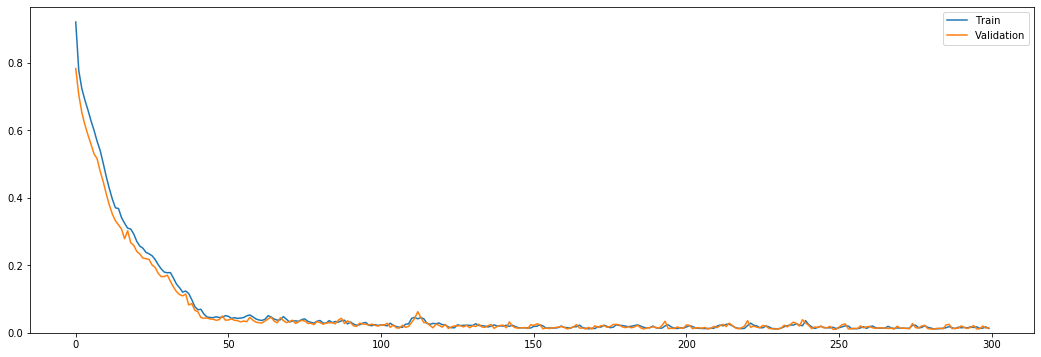

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(X_val)

In [13]:
y_pred[0:2]

array([[0.41804826, 0.4961787 , 0.6204651 , 0.660926  , 0.74483997,
        0.83289   , 0.8739393 , 1.0003191 , 1.0792048 ],
       [0.859744  , 1.0129699 , 1.2717999 , 1.3336984 , 1.5093085 ,
        1.6809381 , 1.748087  , 2.0020866 , 2.1541555 ]], dtype=float32)

## Rewrite to multi-output for each quantile

In [14]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[1])(x)
    out_q2 = Dense(1, name="q2")(x)  # ...
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [15]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [16]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.81128298, 0.36194897, 0.431012  , 0.41013684, 0.85977491,
        0.42128552, 0.42166976, 0.40354603, 0.47146557, 0.42250803,
        0.40243837, 0.42686927, 0.44992118, 0.83710284, 0.42648037,
        0.40455794, 0.45533506, 0.4416203 , 0.44018187, 0.41073501,
        0.39531865, 0.82886827, 0.37881828, 0.40348279, 0.86927252,
        0.42722338, 0.80450429, 0.42121954, 0.41807985, 0.87185556,
        0.87785825, 0.85858611, 0.41152437, 0.41251877, 0.87180258,
        0.43765844, 0.41462572, 0.4143409 , 0.85627792, 0.92359907,
        0.84874455, 0.44157534, 0.40350371, 0.40480417, 0.40318321,
        0.40144885, 0.44090451, 0.85685899, 0.4335312 , 0.42025695,
        0.42924569, 0.88817238, 0.41945536, 0.43180025, 0.39893377,
        0.89810435, 0.40669158, 0.40587732, 0.42109244, 0.42658644,
        0.45097504, 0.40643598, 0.87694607, 0.41230595, 0.88223235,
        0.38546639, 0.44442082, 0.41613937, 0.42775111, 0.90421291,
        0.83740529, 0.87137531, 0.38811858

In [17]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Epoch 1/300
9/9 [==============================] - 0s 34ms/step - loss: 9.9261 - q0_loss: 0.3053 - q1_loss: 0.7635 - q2_loss: 0.9433 - q3_loss: 0.7736 - q4_loss: 1.3789 - q5_loss: 1.9368 - q6_loss: 0.8109 - q7_loss: 1.4670 - q8_loss: 1.5469 - val_loss: 7.6349 - val_q0_loss: 0.1518 - val_q1_loss: 0.7643 - val_q2_loss: 0.5913 - val_q3_loss: 0.4022 - val_q4_loss: 0.8903 - val_q5_loss: 1.3233 - val_q6_loss: 0.7889 - val_q7_loss: 1.4709 - val_q8_loss: 1.2520
Epoch 2/300
9/9 [==============================] - 0s 6ms/step - loss: 8.1377 - q0_loss: 0.1658 - q1_loss: 0.6611 - q2_loss: 1.0011 - q3_loss: 0.6779 - q4_loss: 0.5545 - q5_loss: 2.1845 - q6_loss: 0.6930 - q7_loss: 1.4125 - q8_loss: 0.7873 - val_loss: 7.3238 - val_q0_loss: 0.1304 - val_q1_loss: 0.6325 - val_q2_loss: 0.8538 - val_q3_loss: 0.6022 - val_q4_loss: 0.4935 - val_q5_loss: 1.8229 - val_q6_loss: 0.7017 - val_q7_loss: 1.3288 - val_q8_loss: 0.7581
Epoch 3/300
9/9 [==============================] - 0s 6ms/step - loss: 7.7895 - q0_lo

Epoch 19/300
9/9 [==============================] - 0s 6ms/step - loss: 4.8419 - q0_loss: 0.0526 - q1_loss: 0.4005 - q2_loss: 0.5818 - q3_loss: 0.1106 - q4_loss: 0.0424 - q5_loss: 2.1928 - q6_loss: 0.1191 - q7_loss: 1.2304 - q8_loss: 0.1116 - val_loss: 4.5314 - val_q0_loss: 0.0676 - val_q1_loss: 0.3438 - val_q2_loss: 0.5266 - val_q3_loss: 0.0712 - val_q4_loss: 0.0960 - val_q5_loss: 2.1014 - val_q6_loss: 0.0916 - val_q7_loss: 1.1295 - val_q8_loss: 0.1037
Epoch 20/300
9/9 [==============================] - 0s 6ms/step - loss: 4.7956 - q0_loss: 0.0627 - q1_loss: 0.3747 - q2_loss: 0.5616 - q3_loss: 0.0856 - q4_loss: 0.0772 - q5_loss: 2.2072 - q6_loss: 0.1031 - q7_loss: 1.2089 - q8_loss: 0.1147 - val_loss: 4.4182 - val_q0_loss: 0.0726 - val_q1_loss: 0.3306 - val_q2_loss: 0.4865 - val_q3_loss: 0.0594 - val_q4_loss: 0.0864 - val_q5_loss: 2.0997 - val_q6_loss: 0.0702 - val_q7_loss: 1.1243 - val_q8_loss: 0.0885
Epoch 21/300
9/9 [==============================] - 0s 6ms/step - loss: 4.6380 - q0_

Epoch 37/300
9/9 [==============================] - 0s 6ms/step - loss: 3.1669 - q0_loss: 0.0607 - q1_loss: 0.0979 - q2_loss: 0.1866 - q3_loss: 0.0215 - q4_loss: 0.0530 - q5_loss: 1.7853 - q6_loss: 0.0220 - q7_loss: 0.8819 - q8_loss: 0.0581 - val_loss: 2.8966 - val_q0_loss: 0.0529 - val_q1_loss: 0.0885 - val_q2_loss: 0.1481 - val_q3_loss: 0.0217 - val_q4_loss: 0.0412 - val_q5_loss: 1.6689 - val_q6_loss: 0.0337 - val_q7_loss: 0.7837 - val_q8_loss: 0.0578
Epoch 38/300
9/9 [==============================] - 0s 6ms/step - loss: 3.0803 - q0_loss: 0.0645 - q1_loss: 0.0962 - q2_loss: 0.1649 - q3_loss: 0.0199 - q4_loss: 0.0440 - q5_loss: 1.7573 - q6_loss: 0.0185 - q7_loss: 0.8656 - q8_loss: 0.0495 - val_loss: 2.8620 - val_q0_loss: 0.0539 - val_q1_loss: 0.0853 - val_q2_loss: 0.1045 - val_q3_loss: 0.0229 - val_q4_loss: 0.1087 - val_q5_loss: 1.5338 - val_q6_loss: 0.0276 - val_q7_loss: 0.8174 - val_q8_loss: 0.1080
Epoch 39/300
9/9 [==============================] - 0s 6ms/step - loss: 3.0667 - q0_

Epoch 55/300
9/9 [==============================] - 0s 6ms/step - loss: 2.2541 - q0_loss: 0.0545 - q1_loss: 0.0831 - q2_loss: 0.0949 - q3_loss: 0.0247 - q4_loss: 0.0256 - q5_loss: 1.3839 - q6_loss: 0.0193 - q7_loss: 0.5368 - q8_loss: 0.0313 - val_loss: 2.0507 - val_q0_loss: 0.0474 - val_q1_loss: 0.0653 - val_q2_loss: 0.0815 - val_q3_loss: 0.0231 - val_q4_loss: 0.0546 - val_q5_loss: 1.2130 - val_q6_loss: 0.0163 - val_q7_loss: 0.4950 - val_q8_loss: 0.0547
Epoch 56/300
9/9 [==============================] - 0s 6ms/step - loss: 2.2214 - q0_loss: 0.0524 - q1_loss: 0.0835 - q2_loss: 0.0964 - q3_loss: 0.0287 - q4_loss: 0.0272 - q5_loss: 1.3610 - q6_loss: 0.0180 - q7_loss: 0.5201 - q8_loss: 0.0342 - val_loss: 1.9809 - val_q0_loss: 0.0499 - val_q1_loss: 0.0722 - val_q2_loss: 0.0719 - val_q3_loss: 0.0185 - val_q4_loss: 0.0385 - val_q5_loss: 1.2094 - val_q6_loss: 0.0117 - val_q7_loss: 0.4619 - val_q8_loss: 0.0468
Epoch 57/300
9/9 [==============================] - 0s 5ms/step - loss: 2.2239 - q0_

Epoch 73/300
9/9 [==============================] - 0s 6ms/step - loss: 1.5704 - q0_loss: 0.0362 - q1_loss: 0.0703 - q2_loss: 0.0874 - q3_loss: 0.0267 - q4_loss: 0.0334 - q5_loss: 1.0394 - q6_loss: 0.0298 - q7_loss: 0.2021 - q8_loss: 0.0451 - val_loss: 1.4390 - val_q0_loss: 0.0555 - val_q1_loss: 0.0688 - val_q2_loss: 0.0866 - val_q3_loss: 0.0590 - val_q4_loss: 0.0321 - val_q5_loss: 0.9333 - val_q6_loss: 0.0280 - val_q7_loss: 0.1373 - val_q8_loss: 0.0384
Epoch 74/300
9/9 [==============================] - 0s 6ms/step - loss: 1.5530 - q0_loss: 0.0396 - q1_loss: 0.0674 - q2_loss: 0.0937 - q3_loss: 0.0376 - q4_loss: 0.0342 - q5_loss: 1.0207 - q6_loss: 0.0276 - q7_loss: 0.1889 - q8_loss: 0.0433 - val_loss: 1.3390 - val_q0_loss: 0.0334 - val_q1_loss: 0.0662 - val_q2_loss: 0.0634 - val_q3_loss: 0.0194 - val_q4_loss: 0.0276 - val_q5_loss: 0.9213 - val_q6_loss: 0.0279 - val_q7_loss: 0.1360 - val_q8_loss: 0.0438
Epoch 75/300
9/9 [==============================] - 0s 6ms/step - loss: 1.5616 - q0_

Epoch 91/300
9/9 [==============================] - 0s 5ms/step - loss: 1.1020 - q0_loss: 0.0271 - q1_loss: 0.0499 - q2_loss: 0.0711 - q3_loss: 0.0179 - q4_loss: 0.0304 - q5_loss: 0.6844 - q6_loss: 0.0206 - q7_loss: 0.1582 - q8_loss: 0.0424 - val_loss: 0.9422 - val_q0_loss: 0.0220 - val_q1_loss: 0.0479 - val_q2_loss: 0.0602 - val_q3_loss: 0.0082 - val_q4_loss: 0.0385 - val_q5_loss: 0.5658 - val_q6_loss: 0.0231 - val_q7_loss: 0.1271 - val_q8_loss: 0.0495
Epoch 92/300
9/9 [==============================] - 0s 5ms/step - loss: 1.1033 - q0_loss: 0.0245 - q1_loss: 0.0529 - q2_loss: 0.0693 - q3_loss: 0.0114 - q4_loss: 0.0409 - q5_loss: 0.6666 - q6_loss: 0.0229 - q7_loss: 0.1639 - q8_loss: 0.0509 - val_loss: 0.9508 - val_q0_loss: 0.0310 - val_q1_loss: 0.0440 - val_q2_loss: 0.0586 - val_q3_loss: 0.0284 - val_q4_loss: 0.0399 - val_q5_loss: 0.5622 - val_q6_loss: 0.0209 - val_q7_loss: 0.1221 - val_q8_loss: 0.0438
Epoch 93/300
9/9 [==============================] - 0s 5ms/step - loss: 1.0898 - q0_

Epoch 109/300
9/9 [==============================] - 0s 5ms/step - loss: 0.7290 - q0_loss: 0.0352 - q1_loss: 0.0314 - q2_loss: 0.0597 - q3_loss: 0.0386 - q4_loss: 0.0142 - q5_loss: 0.3521 - q6_loss: 0.0275 - q7_loss: 0.1440 - q8_loss: 0.0264 - val_loss: 0.5893 - val_q0_loss: 0.0352 - val_q1_loss: 0.0289 - val_q2_loss: 0.0666 - val_q3_loss: 0.0398 - val_q4_loss: 0.0104 - val_q5_loss: 0.2540 - val_q6_loss: 0.0258 - val_q7_loss: 0.1100 - val_q8_loss: 0.0187
Epoch 110/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6859 - q0_loss: 0.0295 - q1_loss: 0.0327 - q2_loss: 0.0535 - q3_loss: 0.0283 - q4_loss: 0.0145 - q5_loss: 0.3346 - q6_loss: 0.0201 - q7_loss: 0.1448 - q8_loss: 0.0279 - val_loss: 0.4958 - val_q0_loss: 0.0225 - val_q1_loss: 0.0259 - val_q2_loss: 0.0506 - val_q3_loss: 0.0091 - val_q4_loss: 0.0112 - val_q5_loss: 0.2415 - val_q6_loss: 0.0087 - val_q7_loss: 0.1073 - val_q8_loss: 0.0189
Epoch 111/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6430 - 

Epoch 127/300
9/9 [==============================] - 0s 5ms/step - loss: 0.5932 - q0_loss: 0.0223 - q1_loss: 0.0168 - q2_loss: 0.0333 - q3_loss: 0.0130 - q4_loss: 0.0173 - q5_loss: 0.3188 - q6_loss: 0.0145 - q7_loss: 0.1269 - q8_loss: 0.0303 - val_loss: 0.5153 - val_q0_loss: 0.0290 - val_q1_loss: 0.0216 - val_q2_loss: 0.0334 - val_q3_loss: 0.0337 - val_q4_loss: 0.0103 - val_q5_loss: 0.2332 - val_q6_loss: 0.0225 - val_q7_loss: 0.1117 - val_q8_loss: 0.0200
Epoch 128/300
9/9 [==============================] - 0s 6ms/step - loss: 0.6170 - q0_loss: 0.0241 - q1_loss: 0.0204 - q2_loss: 0.0341 - q3_loss: 0.0210 - q4_loss: 0.0204 - q5_loss: 0.3176 - q6_loss: 0.0157 - q7_loss: 0.1316 - q8_loss: 0.0322 - val_loss: 0.5967 - val_q0_loss: 0.0224 - val_q1_loss: 0.0396 - val_q2_loss: 0.0228 - val_q3_loss: 0.0121 - val_q4_loss: 0.0498 - val_q5_loss: 0.2412 - val_q6_loss: 0.0228 - val_q7_loss: 0.1231 - val_q8_loss: 0.0629
Epoch 129/300
9/9 [==============================] - 0s 6ms/step - loss: 0.6580 - 

Epoch 145/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6153 - q0_loss: 0.0309 - q1_loss: 0.0204 - q2_loss: 0.0257 - q3_loss: 0.0310 - q4_loss: 0.0238 - q5_loss: 0.3069 - q6_loss: 0.0239 - q7_loss: 0.1155 - q8_loss: 0.0370 - val_loss: 0.5656 - val_q0_loss: 0.0310 - val_q1_loss: 0.0299 - val_q2_loss: 0.0266 - val_q3_loss: 0.0285 - val_q4_loss: 0.0515 - val_q5_loss: 0.2365 - val_q6_loss: 0.0178 - val_q7_loss: 0.0905 - val_q8_loss: 0.0535
Epoch 146/300
9/9 [==============================] - 0s 5ms/step - loss: 0.5916 - q0_loss: 0.0256 - q1_loss: 0.0203 - q2_loss: 0.0233 - q3_loss: 0.0249 - q4_loss: 0.0251 - q5_loss: 0.3079 - q6_loss: 0.0146 - q7_loss: 0.1123 - q8_loss: 0.0374 - val_loss: 0.5020 - val_q0_loss: 0.0318 - val_q1_loss: 0.0133 - val_q2_loss: 0.0281 - val_q3_loss: 0.0387 - val_q4_loss: 0.0146 - val_q5_loss: 0.2251 - val_q6_loss: 0.0329 - val_q7_loss: 0.0899 - val_q8_loss: 0.0275
Epoch 147/300
9/9 [==============================] - 0s 5ms/step - loss: 0.6031 - 

Epoch 163/300
9/9 [==============================] - 0s 6ms/step - loss: 0.4904 - q0_loss: 0.0205 - q1_loss: 0.0154 - q2_loss: 0.0083 - q3_loss: 0.0081 - q4_loss: 0.0161 - q5_loss: 0.2922 - q6_loss: 0.0102 - q7_loss: 0.0923 - q8_loss: 0.0274 - val_loss: 0.3998 - val_q0_loss: 0.0215 - val_q1_loss: 0.0139 - val_q2_loss: 0.0095 - val_q3_loss: 0.0091 - val_q4_loss: 0.0120 - val_q5_loss: 0.2154 - val_q6_loss: 0.0127 - val_q7_loss: 0.0829 - val_q8_loss: 0.0228
Epoch 164/300
9/9 [==============================] - 0s 5ms/step - loss: 0.5122 - q0_loss: 0.0213 - q1_loss: 0.0170 - q2_loss: 0.0113 - q3_loss: 0.0116 - q4_loss: 0.0199 - q5_loss: 0.2921 - q6_loss: 0.0159 - q7_loss: 0.0894 - q8_loss: 0.0336 - val_loss: 0.3958 - val_q0_loss: 0.0222 - val_q1_loss: 0.0122 - val_q2_loss: 0.0112 - val_q3_loss: 0.0130 - val_q4_loss: 0.0089 - val_q5_loss: 0.2149 - val_q6_loss: 0.0130 - val_q7_loss: 0.0795 - val_q8_loss: 0.0207
Epoch 165/300
9/9 [==============================] - 0s 6ms/step - loss: 0.5334 - 

Epoch 181/300
9/9 [==============================] - 0s 5ms/step - loss: 0.4557 - q0_loss: 0.0228 - q1_loss: 0.0129 - q2_loss: 0.0143 - q3_loss: 0.0178 - q4_loss: 0.0108 - q5_loss: 0.2774 - q6_loss: 0.0127 - q7_loss: 0.0627 - q8_loss: 0.0243 - val_loss: 0.3737 - val_q0_loss: 0.0213 - val_q1_loss: 0.0156 - val_q2_loss: 0.0092 - val_q3_loss: 0.0089 - val_q4_loss: 0.0159 - val_q5_loss: 0.2045 - val_q6_loss: 0.0150 - val_q7_loss: 0.0581 - val_q8_loss: 0.0254
Epoch 182/300
9/9 [==============================] - 0s 5ms/step - loss: 0.4482 - q0_loss: 0.0221 - q1_loss: 0.0132 - q2_loss: 0.0110 - q3_loss: 0.0130 - q4_loss: 0.0131 - q5_loss: 0.2754 - q6_loss: 0.0102 - q7_loss: 0.0651 - q8_loss: 0.0250 - val_loss: 0.3578 - val_q0_loss: 0.0221 - val_q1_loss: 0.0126 - val_q2_loss: 0.0099 - val_q3_loss: 0.0102 - val_q4_loss: 0.0107 - val_q5_loss: 0.2044 - val_q6_loss: 0.0103 - val_q7_loss: 0.0567 - val_q8_loss: 0.0210
Epoch 183/300
9/9 [==============================] - 0s 5ms/step - loss: 0.4620 - 

Epoch 199/300
9/9 [==============================] - 0s 5ms/step - loss: 0.4000 - q0_loss: 0.0213 - q1_loss: 0.0142 - q2_loss: 0.0083 - q3_loss: 0.0099 - q4_loss: 0.0137 - q5_loss: 0.2599 - q6_loss: 0.0078 - q7_loss: 0.0390 - q8_loss: 0.0258 - val_loss: 0.3494 - val_q0_loss: 0.0225 - val_q1_loss: 0.0144 - val_q2_loss: 0.0118 - val_q3_loss: 0.0115 - val_q4_loss: 0.0180 - val_q5_loss: 0.1928 - val_q6_loss: 0.0171 - val_q7_loss: 0.0340 - val_q8_loss: 0.0272
Epoch 200/300
9/9 [==============================] - 0s 5ms/step - loss: 0.4163 - q0_loss: 0.0224 - q1_loss: 0.0151 - q2_loss: 0.0107 - q3_loss: 0.0121 - q4_loss: 0.0165 - q5_loss: 0.2589 - q6_loss: 0.0128 - q7_loss: 0.0377 - q8_loss: 0.0300 - val_loss: 0.3444 - val_q0_loss: 0.0238 - val_q1_loss: 0.0153 - val_q2_loss: 0.0127 - val_q3_loss: 0.0174 - val_q4_loss: 0.0210 - val_q5_loss: 0.1935 - val_q6_loss: 0.0091 - val_q7_loss: 0.0252 - val_q8_loss: 0.0262
Epoch 201/300
9/9 [==============================] - 0s 5ms/step - loss: 0.4422 - 

Epoch 217/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3932 - q0_loss: 0.0221 - q1_loss: 0.0154 - q2_loss: 0.0131 - q3_loss: 0.0156 - q4_loss: 0.0167 - q5_loss: 0.2397 - q6_loss: 0.0155 - q7_loss: 0.0241 - q8_loss: 0.0310 - val_loss: 0.3514 - val_q0_loss: 0.0217 - val_q1_loss: 0.0196 - val_q2_loss: 0.0077 - val_q3_loss: 0.0076 - val_q4_loss: 0.0252 - val_q5_loss: 0.1768 - val_q6_loss: 0.0159 - val_q7_loss: 0.0444 - val_q8_loss: 0.0325
Epoch 218/300
9/9 [==============================] - 0s 6ms/step - loss: 0.4373 - q0_loss: 0.0215 - q1_loss: 0.0218 - q2_loss: 0.0134 - q3_loss: 0.0135 - q4_loss: 0.0286 - q5_loss: 0.2383 - q6_loss: 0.0205 - q7_loss: 0.0388 - q8_loss: 0.0408 - val_loss: 0.4122 - val_q0_loss: 0.0247 - val_q1_loss: 0.0248 - val_q2_loss: 0.0173 - val_q3_loss: 0.0161 - val_q4_loss: 0.0308 - val_q5_loss: 0.1763 - val_q6_loss: 0.0286 - val_q7_loss: 0.0502 - val_q8_loss: 0.0434
Epoch 219/300
9/9 [==============================] - 0s 5ms/step - loss: 0.4506 - 

Epoch 235/300
9/9 [==============================] - 0s 5ms/step - loss: 0.3848 - q0_loss: 0.0215 - q1_loss: 0.0193 - q2_loss: 0.0096 - q3_loss: 0.0110 - q4_loss: 0.0239 - q5_loss: 0.2183 - q6_loss: 0.0143 - q7_loss: 0.0316 - q8_loss: 0.0352 - val_loss: 0.3032 - val_q0_loss: 0.0235 - val_q1_loss: 0.0117 - val_q2_loss: 0.0171 - val_q3_loss: 0.0194 - val_q4_loss: 0.0133 - val_q5_loss: 0.1617 - val_q6_loss: 0.0191 - val_q7_loss: 0.0131 - val_q8_loss: 0.0243
Epoch 236/300
9/9 [==============================] - 0s 5ms/step - loss: 0.3482 - q0_loss: 0.0223 - q1_loss: 0.0135 - q2_loss: 0.0122 - q3_loss: 0.0139 - q4_loss: 0.0133 - q5_loss: 0.2161 - q6_loss: 0.0124 - q7_loss: 0.0194 - q8_loss: 0.0250 - val_loss: 0.2934 - val_q0_loss: 0.0244 - val_q1_loss: 0.0107 - val_q2_loss: 0.0182 - val_q3_loss: 0.0226 - val_q4_loss: 0.0074 - val_q5_loss: 0.1604 - val_q6_loss: 0.0166 - val_q7_loss: 0.0165 - val_q8_loss: 0.0166
Epoch 237/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3570 - 

Epoch 253/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3473 - q0_loss: 0.0218 - q1_loss: 0.0147 - q2_loss: 0.0152 - q3_loss: 0.0173 - q4_loss: 0.0168 - q5_loss: 0.1935 - q6_loss: 0.0175 - q7_loss: 0.0228 - q8_loss: 0.0279 - val_loss: 0.2897 - val_q0_loss: 0.0220 - val_q1_loss: 0.0172 - val_q2_loss: 0.0086 - val_q3_loss: 0.0082 - val_q4_loss: 0.0190 - val_q5_loss: 0.1448 - val_q6_loss: 0.0133 - val_q7_loss: 0.0266 - val_q8_loss: 0.0300
Epoch 254/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3284 - q0_loss: 0.0210 - q1_loss: 0.0158 - q2_loss: 0.0096 - q3_loss: 0.0092 - q4_loss: 0.0160 - q5_loss: 0.1932 - q6_loss: 0.0134 - q7_loss: 0.0229 - q8_loss: 0.0273 - val_loss: 0.2613 - val_q0_loss: 0.0217 - val_q1_loss: 0.0124 - val_q2_loss: 0.0091 - val_q3_loss: 0.0093 - val_q4_loss: 0.0112 - val_q5_loss: 0.1435 - val_q6_loss: 0.0138 - val_q7_loss: 0.0194 - val_q8_loss: 0.0209
Epoch 255/300
9/9 [==============================] - 0s 5ms/step - loss: 0.3228 - 

Epoch 271/300
9/9 [==============================] - 0s 5ms/step - loss: 0.2802 - q0_loss: 0.0210 - q1_loss: 0.0128 - q2_loss: 0.0090 - q3_loss: 0.0107 - q4_loss: 0.0105 - q5_loss: 0.1681 - q6_loss: 0.0089 - q7_loss: 0.0162 - q8_loss: 0.0229 - val_loss: 0.2466 - val_q0_loss: 0.0218 - val_q1_loss: 0.0129 - val_q2_loss: 0.0094 - val_q3_loss: 0.0106 - val_q4_loss: 0.0124 - val_q5_loss: 0.1252 - val_q6_loss: 0.0128 - val_q7_loss: 0.0188 - val_q8_loss: 0.0226
Epoch 272/300
9/9 [==============================] - 0s 6ms/step - loss: 0.2930 - q0_loss: 0.0204 - q1_loss: 0.0151 - q2_loss: 0.0077 - q3_loss: 0.0080 - q4_loss: 0.0153 - q5_loss: 0.1668 - q6_loss: 0.0099 - q7_loss: 0.0214 - q8_loss: 0.0284 - val_loss: 0.3464 - val_q0_loss: 0.0213 - val_q1_loss: 0.0266 - val_q2_loss: 0.0094 - val_q3_loss: 0.0064 - val_q4_loss: 0.0362 - val_q5_loss: 0.1259 - val_q6_loss: 0.0232 - val_q7_loss: 0.0494 - val_q8_loss: 0.0480
Epoch 273/300
9/9 [==============================] - 0s 5ms/step - loss: 0.3548 - 

Epoch 289/300
9/9 [==============================] - 0s 6ms/step - loss: 0.2721 - q0_loss: 0.0218 - q1_loss: 0.0136 - q2_loss: 0.0116 - q3_loss: 0.0133 - q4_loss: 0.0130 - q5_loss: 0.1408 - q6_loss: 0.0131 - q7_loss: 0.0193 - q8_loss: 0.0257 - val_loss: 0.2284 - val_q0_loss: 0.0218 - val_q1_loss: 0.0138 - val_q2_loss: 0.0094 - val_q3_loss: 0.0107 - val_q4_loss: 0.0114 - val_q5_loss: 0.1066 - val_q6_loss: 0.0107 - val_q7_loss: 0.0208 - val_q8_loss: 0.0232
Epoch 290/300
9/9 [==============================] - 0s 5ms/step - loss: 0.2643 - q0_loss: 0.0222 - q1_loss: 0.0148 - q2_loss: 0.0101 - q3_loss: 0.0115 - q4_loss: 0.0134 - q5_loss: 0.1396 - q6_loss: 0.0088 - q7_loss: 0.0192 - q8_loss: 0.0246 - val_loss: 0.2491 - val_q0_loss: 0.0234 - val_q1_loss: 0.0154 - val_q2_loss: 0.0112 - val_q3_loss: 0.0133 - val_q4_loss: 0.0206 - val_q5_loss: 0.1039 - val_q6_loss: 0.0114 - val_q7_loss: 0.0220 - val_q8_loss: 0.0281
Epoch 291/300
9/9 [==============================] - 0s 5ms/step - loss: 0.2534 - 

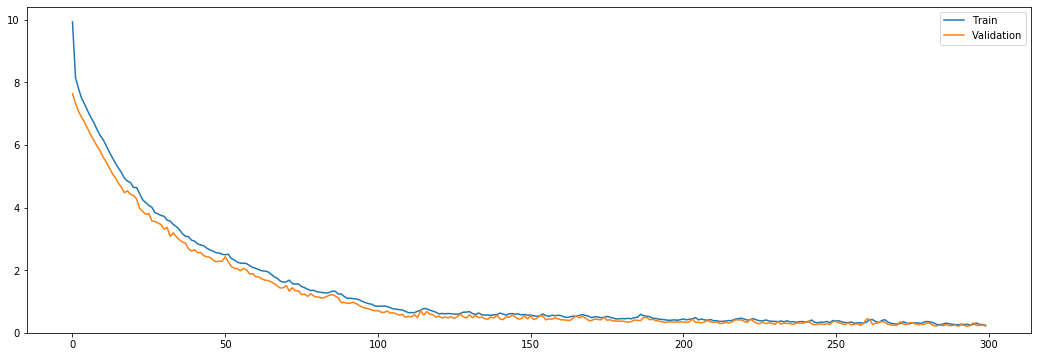

In [18]:
plot_loss(history)

In [19]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.41992426, 0.5055728 , 0.6261836 , 0.662639  , 0.7605119 ,
        0.8510222 , 0.8831183 , 1.0195371 , 1.0943499 ],
       [0.863505  , 1.0151409 , 1.2584714 , 1.3303823 , 1.5046526 ,
        1.2839731 , 1.7452959 , 1.9986054 , 2.148717  ]], dtype=float32)

**Note**: training seems slower! 

## Employ pinball loss

In [20]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [21]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

In [22]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [23]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Epoch 1/300
9/9 [==============================] - 0s 33ms/step - loss: 9.8491 - q0_loss: 0.7520 - q1_loss: 0.0960 - q2_loss: 0.8834 - q3_loss: 0.9975 - q4_loss: 0.4081 - q5_loss: 1.4817 - q6_loss: 1.2517 - q7_loss: 3.0605 - q8_loss: 0.9183 - val_loss: 5.7274 - val_q0_loss: 0.0056 - val_q1_loss: 0.2121 - val_q2_loss: 0.2063 - val_q3_loss: 0.4209 - val_q4_loss: 0.3288 - val_q5_loss: 1.1122 - val_q6_loss: 0.8236 - val_q7_loss: 0.3059 - val_q8_loss: 2.3118
Epoch 2/300
9/9 [==============================] - 0s 6ms/step - loss: 6.2466 - q0_loss: 0.0341 - q1_loss: 0.7999 - q2_loss: 0.2516 - q3_loss: 0.3566 - q4_loss: 0.6275 - q5_loss: 0.7057 - q6_loss: 0.8069 - q7_loss: 0.6331 - q8_loss: 2.0311 - val_loss: 5.2639 - val_q0_loss: 0.1348 - val_q1_loss: 0.1995 - val_q2_loss: 0.1501 - val_q3_loss: 0.3002 - val_q4_loss: 0.6511 - val_q5_loss: 0.4930 - val_q6_loss: 0.8295 - val_q7_loss: 1.4396 - val_q8_loss: 1.0659
Epoch 3/300
9/9 [==============================] - 0s 6ms/step - loss: 5.4717 - q0_lo

Epoch 19/300
9/9 [==============================] - 0s 6ms/step - loss: 3.5669 - q0_loss: 6.6103e-04 - q1_loss: 0.0061 - q2_loss: 0.1073 - q3_loss: 0.0201 - q4_loss: 0.6568 - q5_loss: 0.0186 - q6_loss: 0.6939 - q7_loss: 1.7396 - q8_loss: 0.3240 - val_loss: 3.3038 - val_q0_loss: 5.2223e-04 - val_q1_loss: 0.0282 - val_q2_loss: 0.1123 - val_q3_loss: 0.0145 - val_q4_loss: 0.6475 - val_q5_loss: 0.0509 - val_q6_loss: 0.6002 - val_q7_loss: 1.5732 - val_q8_loss: 0.2762
Epoch 20/300
9/9 [==============================] - 0s 7ms/step - loss: 3.5002 - q0_loss: 6.3418e-04 - q1_loss: 0.0092 - q2_loss: 0.1066 - q3_loss: 0.0126 - q4_loss: 0.6568 - q5_loss: 0.0227 - q6_loss: 0.6729 - q7_loss: 1.7261 - q8_loss: 0.2927 - val_loss: 3.2037 - val_q0_loss: 5.4325e-04 - val_q1_loss: 0.0057 - val_q2_loss: 0.0959 - val_q3_loss: 0.0075 - val_q4_loss: 0.6015 - val_q5_loss: 0.0150 - val_q6_loss: 0.6203 - val_q7_loss: 1.6043 - val_q8_loss: 0.2531
Epoch 21/300
9/9 [==============================] - 0s 6ms/step - lo

Epoch 37/300
9/9 [==============================] - 0s 6ms/step - loss: 2.3846 - q0_loss: 7.8605e-04 - q1_loss: 0.0139 - q2_loss: 0.0851 - q3_loss: 0.0195 - q4_loss: 0.5438 - q5_loss: 0.0252 - q6_loss: 0.3454 - q7_loss: 1.2977 - q8_loss: 0.0532 - val_loss: 2.1290 - val_q0_loss: 5.7171e-04 - val_q1_loss: 0.0033 - val_q2_loss: 0.0753 - val_q3_loss: 0.0188 - val_q4_loss: 0.5011 - val_q5_loss: 0.0301 - val_q6_loss: 0.2905 - val_q7_loss: 1.1979 - val_q8_loss: 0.0114
Epoch 38/300
9/9 [==============================] - 0s 7ms/step - loss: 2.3155 - q0_loss: 6.8821e-04 - q1_loss: 0.0114 - q2_loss: 0.0838 - q3_loss: 0.0210 - q4_loss: 0.5358 - q5_loss: 0.0252 - q6_loss: 0.3235 - q7_loss: 1.2669 - q8_loss: 0.0471 - val_loss: 2.0641 - val_q0_loss: 6.6222e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.0726 - val_q3_loss: 0.0159 - val_q4_loss: 0.4825 - val_q5_loss: 0.0156 - val_q6_loss: 0.2889 - val_q7_loss: 1.1686 - val_q8_loss: 0.0175
Epoch 39/300
9/9 [==============================] - 0s 6ms/step - lo

Epoch 55/300
9/9 [==============================] - 0s 6ms/step - loss: 1.0266 - q0_loss: 0.0013 - q1_loss: 0.0520 - q2_loss: 0.0758 - q3_loss: 0.0279 - q4_loss: 0.3292 - q5_loss: 0.0302 - q6_loss: 0.0630 - q7_loss: 0.4237 - q8_loss: 0.0234 - val_loss: 0.8336 - val_q0_loss: 0.0014 - val_q1_loss: 0.0038 - val_q2_loss: 0.0671 - val_q3_loss: 0.0306 - val_q4_loss: 0.2809 - val_q5_loss: 0.0267 - val_q6_loss: 0.0525 - val_q7_loss: 0.3435 - val_q8_loss: 0.0273
Epoch 56/300
9/9 [==============================] - 0s 6ms/step - loss: 0.9219 - q0_loss: 0.0014 - q1_loss: 0.0357 - q2_loss: 0.0747 - q3_loss: 0.0280 - q4_loss: 0.3108 - q5_loss: 0.0223 - q6_loss: 0.0580 - q7_loss: 0.3720 - q8_loss: 0.0191 - val_loss: 0.7122 - val_q0_loss: 0.0015 - val_q1_loss: 0.0096 - val_q2_loss: 0.0691 - val_q3_loss: 0.0323 - val_q4_loss: 0.2612 - val_q5_loss: 0.0128 - val_q6_loss: 0.0501 - val_q7_loss: 0.2583 - val_q8_loss: 0.0173
Epoch 57/300
9/9 [==============================] - 0s 7ms/step - loss: 0.8522 - q0_

Epoch 73/300
9/9 [==============================] - 0s 6ms/step - loss: 0.2276 - q0_loss: 0.0015 - q1_loss: 0.0090 - q2_loss: 0.0387 - q3_loss: 0.0275 - q4_loss: 0.0871 - q5_loss: 0.0259 - q6_loss: 0.0221 - q7_loss: 0.0113 - q8_loss: 0.0044 - val_loss: 0.2896 - val_q0_loss: 0.0019 - val_q1_loss: 0.0072 - val_q2_loss: 0.0379 - val_q3_loss: 0.0456 - val_q4_loss: 0.0760 - val_q5_loss: 0.0735 - val_q6_loss: 0.0170 - val_q7_loss: 0.0064 - val_q8_loss: 0.0242
Epoch 74/300
9/9 [==============================] - 0s 6ms/step - loss: 0.2403 - q0_loss: 0.0016 - q1_loss: 0.0103 - q2_loss: 0.0368 - q3_loss: 0.0289 - q4_loss: 0.0873 - q5_loss: 0.0388 - q6_loss: 0.0224 - q7_loss: 0.0094 - q8_loss: 0.0048 - val_loss: 0.1917 - val_q0_loss: 0.0016 - val_q1_loss: 0.0145 - val_q2_loss: 0.0306 - val_q3_loss: 0.0175 - val_q4_loss: 0.0723 - val_q5_loss: 0.0219 - val_q6_loss: 0.0257 - val_q7_loss: 0.0068 - val_q8_loss: 8.7682e-04
Epoch 75/300
9/9 [==============================] - 0s 6ms/step - loss: 0.1956 -

Epoch 91/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1658 - q0_loss: 0.0012 - q1_loss: 0.0091 - q2_loss: 0.0339 - q3_loss: 0.0128 - q4_loss: 0.0633 - q5_loss: 0.0305 - q6_loss: 0.0102 - q7_loss: 0.0034 - q8_loss: 0.0013 - val_loss: 0.1749 - val_q0_loss: 0.0014 - val_q1_loss: 0.0138 - val_q2_loss: 0.0328 - val_q3_loss: 0.0220 - val_q4_loss: 0.0637 - val_q5_loss: 0.0207 - val_q6_loss: 0.0136 - val_q7_loss: 0.0060 - val_q8_loss: 9.8888e-04
Epoch 92/300
9/9 [==============================] - 0s 6ms/step - loss: 0.1848 - q0_loss: 0.0013 - q1_loss: 0.0135 - q2_loss: 0.0363 - q3_loss: 0.0168 - q4_loss: 0.0667 - q5_loss: 0.0292 - q6_loss: 0.0138 - q7_loss: 0.0060 - q8_loss: 0.0012 - val_loss: 0.1778 - val_q0_loss: 0.0010 - val_q1_loss: 0.0127 - val_q2_loss: 0.0329 - val_q3_loss: 0.0238 - val_q4_loss: 0.0529 - val_q5_loss: 0.0298 - val_q6_loss: 0.0169 - val_q7_loss: 0.0061 - val_q8_loss: 0.0017
Epoch 93/300
9/9 [==============================] - 0s 6ms/step - loss: 0.1821 -

Epoch 109/300
9/9 [==============================] - 0s 6ms/step - loss: 0.1349 - q0_loss: 0.0011 - q1_loss: 0.0095 - q2_loss: 0.0333 - q3_loss: 0.0114 - q4_loss: 0.0413 - q5_loss: 0.0241 - q6_loss: 0.0080 - q7_loss: 0.0048 - q8_loss: 0.0013 - val_loss: 0.1002 - val_q0_loss: 0.0010 - val_q1_loss: 0.0109 - val_q2_loss: 0.0233 - val_q3_loss: 0.0055 - val_q4_loss: 0.0298 - val_q5_loss: 0.0187 - val_q6_loss: 0.0064 - val_q7_loss: 0.0033 - val_q8_loss: 0.0013
Epoch 110/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1204 - q0_loss: 0.0011 - q1_loss: 0.0099 - q2_loss: 0.0323 - q3_loss: 0.0098 - q4_loss: 0.0362 - q5_loss: 0.0206 - q6_loss: 0.0051 - q7_loss: 0.0041 - q8_loss: 0.0013 - val_loss: 0.1160 - val_q0_loss: 9.3605e-04 - val_q1_loss: 0.0115 - val_q2_loss: 0.0284 - val_q3_loss: 0.0084 - val_q4_loss: 0.0270 - val_q5_loss: 0.0182 - val_q6_loss: 0.0053 - val_q7_loss: 0.0148 - val_q8_loss: 0.0013
Epoch 111/300
9/9 [==============================] - 0s 6ms/step - loss: 0.132

Epoch 127/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1415 - q0_loss: 0.0011 - q1_loss: 0.0108 - q2_loss: 0.0373 - q3_loss: 0.0244 - q4_loss: 0.0245 - q5_loss: 0.0256 - q6_loss: 0.0099 - q7_loss: 0.0067 - q8_loss: 0.0012 - val_loss: 0.1041 - val_q0_loss: 8.1591e-04 - val_q1_loss: 0.0105 - val_q2_loss: 0.0228 - val_q3_loss: 0.0111 - val_q4_loss: 0.0191 - val_q5_loss: 0.0223 - val_q6_loss: 0.0107 - val_q7_loss: 0.0051 - val_q8_loss: 0.0016
Epoch 128/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1075 - q0_loss: 0.0010 - q1_loss: 0.0101 - q2_loss: 0.0330 - q3_loss: 0.0122 - q4_loss: 0.0215 - q5_loss: 0.0148 - q6_loss: 0.0071 - q7_loss: 0.0064 - q8_loss: 0.0013 - val_loss: 0.0703 - val_q0_loss: 8.3745e-04 - val_q1_loss: 0.0122 - val_q2_loss: 0.0220 - val_q3_loss: 0.0052 - val_q4_loss: 0.0139 - val_q5_loss: 0.0084 - val_q6_loss: 0.0033 - val_q7_loss: 0.0031 - val_q8_loss: 0.0014
Epoch 129/300
9/9 [==============================] - 0s 6ms/step - loss: 0

Epoch 145/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0758 - q0_loss: 7.7339e-04 - q1_loss: 0.0103 - q2_loss: 0.0276 - q3_loss: 0.0092 - q4_loss: 0.0066 - q5_loss: 0.0115 - q6_loss: 0.0042 - q7_loss: 0.0044 - q8_loss: 0.0014 - val_loss: 0.0691 - val_q0_loss: 7.6522e-04 - val_q1_loss: 0.0116 - val_q2_loss: 0.0210 - val_q3_loss: 0.0103 - val_q4_loss: 0.0033 - val_q5_loss: 0.0122 - val_q6_loss: 0.0053 - val_q7_loss: 0.0034 - val_q8_loss: 0.0012
Epoch 146/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0761 - q0_loss: 7.6318e-04 - q1_loss: 0.0103 - q2_loss: 0.0285 - q3_loss: 0.0110 - q4_loss: 0.0043 - q5_loss: 0.0112 - q6_loss: 0.0044 - q7_loss: 0.0042 - q8_loss: 0.0014 - val_loss: 0.0827 - val_q0_loss: 6.1988e-04 - val_q1_loss: 0.0119 - val_q2_loss: 0.0242 - val_q3_loss: 0.0121 - val_q4_loss: 0.0104 - val_q5_loss: 0.0117 - val_q6_loss: 0.0064 - val_q7_loss: 0.0039 - val_q8_loss: 0.0014
Epoch 147/300
9/9 [==============================] - 0s 6ms/step -

Epoch 163/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1157 - q0_loss: 6.6169e-04 - q1_loss: 0.0110 - q2_loss: 0.0281 - q3_loss: 0.0221 - q4_loss: 0.0132 - q5_loss: 0.0230 - q6_loss: 0.0113 - q7_loss: 0.0050 - q8_loss: 0.0014 - val_loss: 0.1102 - val_q0_loss: 7.2208e-04 - val_q1_loss: 0.0117 - val_q2_loss: 0.0215 - val_q3_loss: 0.0197 - val_q4_loss: 0.0181 - val_q5_loss: 0.0195 - val_q6_loss: 0.0155 - val_q7_loss: 0.0024 - val_q8_loss: 0.0011
Epoch 164/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1032 - q0_loss: 7.3535e-04 - q1_loss: 0.0101 - q2_loss: 0.0266 - q3_loss: 0.0184 - q4_loss: 0.0142 - q5_loss: 0.0177 - q6_loss: 0.0102 - q7_loss: 0.0041 - q8_loss: 0.0012 - val_loss: 0.1001 - val_q0_loss: 4.4043e-04 - val_q1_loss: 0.0104 - val_q2_loss: 0.0241 - val_q3_loss: 0.0190 - val_q4_loss: 0.0075 - val_q5_loss: 0.0231 - val_q6_loss: 0.0107 - val_q7_loss: 0.0031 - val_q8_loss: 0.0018
Epoch 165/300
9/9 [==============================] - 0s 6ms/step -

Epoch 181/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0700 - q0_loss: 6.0413e-04 - q1_loss: 0.0094 - q2_loss: 0.0217 - q3_loss: 0.0110 - q4_loss: 0.0083 - q5_loss: 0.0092 - q6_loss: 0.0041 - q7_loss: 0.0044 - q8_loss: 0.0013 - val_loss: 0.0641 - val_q0_loss: 3.9767e-04 - val_q1_loss: 0.0105 - val_q2_loss: 0.0164 - val_q3_loss: 0.0128 - val_q4_loss: 0.0061 - val_q5_loss: 0.0089 - val_q6_loss: 0.0048 - val_q7_loss: 0.0027 - val_q8_loss: 0.0015
Epoch 182/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0626 - q0_loss: 5.1166e-04 - q1_loss: 0.0094 - q2_loss: 0.0193 - q3_loss: 0.0084 - q4_loss: 0.0068 - q5_loss: 0.0081 - q6_loss: 0.0048 - q7_loss: 0.0038 - q8_loss: 0.0013 - val_loss: 0.0697 - val_q0_loss: 4.7884e-04 - val_q1_loss: 0.0111 - val_q2_loss: 0.0142 - val_q3_loss: 0.0084 - val_q4_loss: 0.0133 - val_q5_loss: 0.0079 - val_q6_loss: 0.0093 - val_q7_loss: 0.0037 - val_q8_loss: 0.0012
Epoch 183/300
9/9 [==============================] - 0s 7ms/step -

Epoch 199/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0684 - q0_loss: 5.1305e-04 - q1_loss: 0.0092 - q2_loss: 0.0160 - q3_loss: 0.0080 - q4_loss: 0.0134 - q5_loss: 0.0079 - q6_loss: 0.0064 - q7_loss: 0.0057 - q8_loss: 0.0013 - val_loss: 0.0496 - val_q0_loss: 4.1456e-04 - val_q1_loss: 0.0103 - val_q2_loss: 0.0123 - val_q3_loss: 0.0053 - val_q4_loss: 0.0051 - val_q5_loss: 0.0075 - val_q6_loss: 0.0048 - val_q7_loss: 0.0024 - val_q8_loss: 0.0014
Epoch 200/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0707 - q0_loss: 5.3481e-04 - q1_loss: 0.0093 - q2_loss: 0.0172 - q3_loss: 0.0113 - q4_loss: 0.0112 - q5_loss: 0.0105 - q6_loss: 0.0053 - q7_loss: 0.0040 - q8_loss: 0.0013 - val_loss: 0.0773 - val_q0_loss: 4.1645e-04 - val_q1_loss: 0.0091 - val_q2_loss: 0.0161 - val_q3_loss: 0.0093 - val_q4_loss: 0.0175 - val_q5_loss: 0.0101 - val_q6_loss: 0.0090 - val_q7_loss: 0.0043 - val_q8_loss: 0.0015
Epoch 201/300
9/9 [==============================] - 0s 6ms/step -

Epoch 217/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0899 - q0_loss: 5.4697e-04 - q1_loss: 0.0093 - q2_loss: 0.0176 - q3_loss: 0.0177 - q4_loss: 0.0161 - q5_loss: 0.0153 - q6_loss: 0.0071 - q7_loss: 0.0050 - q8_loss: 0.0012 - val_loss: 0.1167 - val_q0_loss: 6.4879e-04 - val_q1_loss: 0.0111 - val_q2_loss: 0.0149 - val_q3_loss: 0.0220 - val_q4_loss: 0.0187 - val_q5_loss: 0.0212 - val_q6_loss: 0.0256 - val_q7_loss: 0.0017 - val_q8_loss: 8.5689e-04
Epoch 218/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1108 - q0_loss: 6.1109e-04 - q1_loss: 0.0106 - q2_loss: 0.0192 - q3_loss: 0.0225 - q4_loss: 0.0191 - q5_loss: 0.0217 - q6_loss: 0.0115 - q7_loss: 0.0044 - q8_loss: 0.0012 - val_loss: 0.1005 - val_q0_loss: 0.0011 - val_q1_loss: 0.0103 - val_q2_loss: 0.0197 - val_q3_loss: 0.0207 - val_q4_loss: 0.0135 - val_q5_loss: 0.0223 - val_q6_loss: 0.0072 - val_q7_loss: 0.0041 - val_q8_loss: 0.0017
Epoch 219/300
9/9 [==============================] - 0s 7ms/step -

9/9 [==============================] - 0s 5ms/step - loss: 0.0566 - q0_loss: 4.4186e-04 - q1_loss: 0.0090 - q2_loss: 0.0096 - q3_loss: 0.0097 - q4_loss: 0.0107 - q5_loss: 0.0077 - q6_loss: 0.0053 - q7_loss: 0.0031 - q8_loss: 0.0012 - val_loss: 0.0625 - val_q0_loss: 5.7714e-04 - val_q1_loss: 0.0099 - val_q2_loss: 0.0123 - val_q3_loss: 0.0145 - val_q4_loss: 0.0057 - val_q5_loss: 0.0113 - val_q6_loss: 0.0050 - val_q7_loss: 0.0019 - val_q8_loss: 0.0013
Epoch 235/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0581 - q0_loss: 4.4429e-04 - q1_loss: 0.0089 - q2_loss: 0.0109 - q3_loss: 0.0106 - q4_loss: 0.0079 - q5_loss: 0.0099 - q6_loss: 0.0050 - q7_loss: 0.0033 - q8_loss: 0.0012 - val_loss: 0.0553 - val_q0_loss: 4.6117e-04 - val_q1_loss: 0.0096 - val_q2_loss: 0.0072 - val_q3_loss: 0.0102 - val_q4_loss: 0.0132 - val_q5_loss: 0.0048 - val_q6_loss: 0.0050 - val_q7_loss: 0.0037 - val_q8_loss: 0.0011
Epoch 236/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0661 

Epoch 252/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0474 - q0_loss: 5.1430e-04 - q1_loss: 0.0088 - q2_loss: 0.0066 - q3_loss: 0.0104 - q4_loss: 0.0060 - q5_loss: 0.0077 - q6_loss: 0.0030 - q7_loss: 0.0032 - q8_loss: 0.0011 - val_loss: 0.0416 - val_q0_loss: 5.0549e-04 - val_q1_loss: 0.0092 - val_q2_loss: 0.0051 - val_q3_loss: 0.0097 - val_q4_loss: 0.0054 - val_q5_loss: 0.0054 - val_q6_loss: 0.0031 - val_q7_loss: 0.0021 - val_q8_loss: 0.0010
Epoch 253/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0434 - q0_loss: 4.7832e-04 - q1_loss: 0.0087 - q2_loss: 0.0060 - q3_loss: 0.0080 - q4_loss: 0.0056 - q5_loss: 0.0075 - q6_loss: 0.0038 - q7_loss: 0.0021 - q8_loss: 0.0011 - val_loss: 0.0541 - val_q0_loss: 3.7689e-04 - val_q1_loss: 0.0090 - val_q2_loss: 0.0096 - val_q3_loss: 0.0045 - val_q4_loss: 0.0098 - val_q5_loss: 0.0106 - val_q6_loss: 0.0064 - val_q7_loss: 0.0025 - val_q8_loss: 0.0013
Epoch 254/300
9/9 [==============================] - 0s 5ms/step -

9/9 [==============================] - 0s 5ms/step - loss: 0.0601 - q0_loss: 4.6968e-04 - q1_loss: 0.0087 - q2_loss: 0.0072 - q3_loss: 0.0115 - q4_loss: 0.0086 - q5_loss: 0.0128 - q6_loss: 0.0077 - q7_loss: 0.0021 - q8_loss: 0.0010 - val_loss: 0.0565 - val_q0_loss: 4.1747e-04 - val_q1_loss: 0.0100 - val_q2_loss: 0.0030 - val_q3_loss: 0.0046 - val_q4_loss: 0.0169 - val_q5_loss: 0.0095 - val_q6_loss: 0.0078 - val_q7_loss: 0.0033 - val_q8_loss: 0.0011
Epoch 270/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0552 - q0_loss: 5.4826e-04 - q1_loss: 0.0087 - q2_loss: 0.0055 - q3_loss: 0.0115 - q4_loss: 0.0115 - q5_loss: 0.0090 - q6_loss: 0.0042 - q7_loss: 0.0032 - q8_loss: 9.8992e-04 - val_loss: 0.0856 - val_q0_loss: 0.0015 - val_q1_loss: 0.0097 - val_q2_loss: 0.0135 - val_q3_loss: 0.0247 - val_q4_loss: 0.0110 - val_q5_loss: 0.0151 - val_q6_loss: 0.0050 - val_q7_loss: 0.0036 - val_q8_loss: 0.0014
Epoch 271/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0480 

9/9 [==============================] - 0s 6ms/step - loss: 0.0405 - q0_loss: 4.8183e-04 - q1_loss: 0.0083 - q2_loss: 0.0053 - q3_loss: 0.0082 - q4_loss: 0.0045 - q5_loss: 0.0070 - q6_loss: 0.0043 - q7_loss: 0.0014 - q8_loss: 9.6750e-04 - val_loss: 0.0623 - val_q0_loss: 5.4463e-04 - val_q1_loss: 0.0094 - val_q2_loss: 0.0077 - val_q3_loss: 0.0132 - val_q4_loss: 0.0063 - val_q5_loss: 0.0141 - val_q6_loss: 0.0092 - val_q7_loss: 0.0011 - val_q8_loss: 7.4875e-04
Epoch 287/300
9/9 [==============================] - 0s 6ms/step - loss: 0.0441 - q0_loss: 4.6662e-04 - q1_loss: 0.0083 - q2_loss: 0.0056 - q3_loss: 0.0093 - q4_loss: 0.0044 - q5_loss: 0.0088 - q6_loss: 0.0049 - q7_loss: 0.0015 - q8_loss: 9.5998e-04 - val_loss: 0.0385 - val_q0_loss: 4.2002e-04 - val_q1_loss: 0.0085 - val_q2_loss: 0.0020 - val_q3_loss: 0.0036 - val_q4_loss: 0.0090 - val_q5_loss: 0.0067 - val_q6_loss: 0.0053 - val_q7_loss: 0.0019 - val_q8_loss: 0.0010
Epoch 288/300
9/9 [==============================] - 0s 6ms/step - l

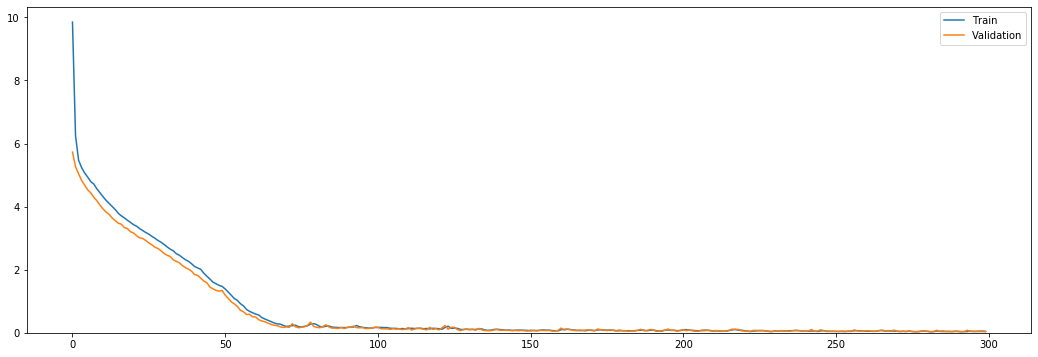

In [24]:
plot_loss(history)

In [25]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.33720022, 0.06153324, 0.5972222 , 0.6344596 , 0.75691557,
        0.85870445, 0.9006228 , 1.0520642 , 1.2561781 ],
       [0.72466165, 0.9620757 , 1.207474  , 1.2827312 , 1.4963367 ,
        1.6775134 , 1.756339  , 2.082702  , 2.2786772 ]], dtype=float32)

**Note**: the distribution of predictions is wider than when trained with the MAE. This is in line with what we would expect: over-predicting the lower quantiles is punished much harder than before, and the same for under-predicting the higher quantiles.

## Test pinball loss

In [26]:
# from https://github.com/keras-team/keras/pull/8033/files
def test_pinball_loss():
    y_pred = K.variable(np.array([0.3, 0.6, 0.1]))
    y_true = K.variable(np.array([0.3, 0.4, 0.5]))
    quantile = 0.25
    loss_fcn = create_pinball_loss(tau=quantile)#losses.PinballLoss(quantile)
    expected_loss = (quantile * 0.4 + (1 - quantile) * 0.2) / 3
    loss = K.eval(loss_fcn(y_true, y_pred))
    assert np.isclose(expected_loss, loss)

test_pinball_loss()